In [42]:
import torch
import torch.nn as nn
import torch.nn.init as init
import os
from torch import linalg as LA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import math

print(torch.cuda.is_available())

True


In [43]:
device='cuda' 


# Define network parameters
W1 = torch.randn(20, 10, device=device, requires_grad=True)
b1 = torch.randn(20, 1, device=device, requires_grad=True)
W2 = torch.randn(20, 1, device=device, requires_grad=True)
b2 = torch.randn(1, device=device, requires_grad=True)

# Define forward pass function
def forward(x):
    z = torch.matmul(W1, x) + b1
    a = torch.tanh(z)
    y_hat = torch.matmul(W2.T, a) + b2
    return y_hat

# Define loss function
def loss(y_hat, y):
    return torch.mean(torch.abs(y_hat - y))

# Generate random input and output data
x = torch.randn(100, 10, 1, device=device)
y = torch.randn(100, 1, 1, device=device)

# Compute forward pass and loss
y_hat = forward(x)
L = loss(y_hat, y)

# Compute gradients with autograd
L.backward()
auto_W1 = W1.grad
auto_b1 = b1.grad
auto_W2 = W2.grad
auto_b2 = b2.grad

# Compute gradients manually
hand_b2 = torch.mean(torch.sign(y_hat - y), dim=0)
hand_W2 = torch.mean(torch.sign(y_hat - y) * torch.tanh(torch.matmul(W1, x) + b1), dim=0)
hand_b1 = torch.mean(torch.sign(y_hat - y) * W2 * (1 - torch.tanh(torch.matmul(W1, x) + b1) ** 2), dim=0)
hand_W1 = torch.mean(torch.matmul(torch.sign(y_hat - y) * W2 * (1 - torch.tanh(torch.matmul(W1, x) + b1) ** 2), x.permute(0, 2, 1)), dim=0)


# Compare gradients
print('W1 diff:', torch.linalg.norm(auto_W1 - hand_W1))
print('b1 diff:', torch.linalg.norm(auto_b1 - hand_b1))
print('W2 diff:', torch.linalg.norm(auto_W2 - hand_W2))
print('b2 diff:', torch.linalg.norm(auto_b2 - hand_b2))



W1 diff: tensor(9.7264e-08, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
b1 diff: tensor(2.3148e-08, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
W2 diff: tensor(6.9843e-08, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
b2 diff: tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


Epoch: 0 Train loss: tensor(0.8954, grad_fn=<MeanBackward0>) Test loss: tensor(0.8932, grad_fn=<MeanBackward0>)
Epoch: 1 Train loss: tensor(0.8925, grad_fn=<MeanBackward0>) Test loss: tensor(0.8918, grad_fn=<MeanBackward0>)
Epoch: 2 Train loss: tensor(0.8896, grad_fn=<MeanBackward0>) Test loss: tensor(0.8879, grad_fn=<MeanBackward0>)
Epoch: 3 Train loss: tensor(0.8905, grad_fn=<MeanBackward0>) Test loss: tensor(0.8899, grad_fn=<MeanBackward0>)
Epoch: 4 Train loss: tensor(0.8888, grad_fn=<MeanBackward0>) Test loss: tensor(0.8877, grad_fn=<MeanBackward0>)
Epoch: 5 Train loss: tensor(0.8894, grad_fn=<MeanBackward0>) Test loss: tensor(0.8886, grad_fn=<MeanBackward0>)
Epoch: 6 Train loss: tensor(0.8884, grad_fn=<MeanBackward0>) Test loss: tensor(0.8868, grad_fn=<MeanBackward0>)
Epoch: 7 Train loss: tensor(0.8894, grad_fn=<MeanBackward0>) Test loss: tensor(0.8886, grad_fn=<MeanBackward0>)
Epoch: 8 Train loss: tensor(0.8878, grad_fn=<MeanBackward0>) Test loss: tensor(0.8866, grad_fn=<MeanBack

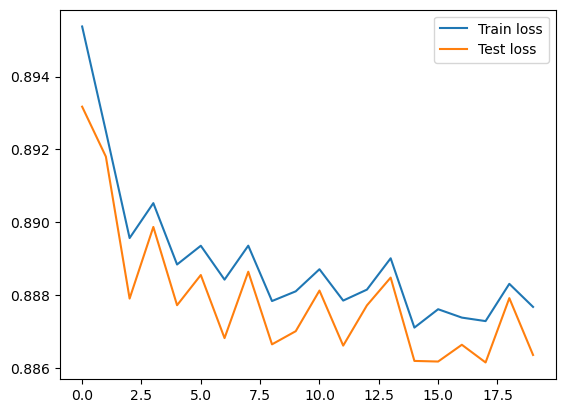

In [55]:
# Train this model on the sklearn California Housing Prices datasets.
# • For this you may use the optimizer and learning rates of your choice and train
# for 20-50 epochs.
# • Take half the data for training and half for testing.
# • Create a validation set from the training set and use it to select a good learning
# rate.
# • You might want to use the convenient Xavier initialization.
# • You are free to use the torch.optim package for this part.
# • To speed up things, run the training loop by batches (e.g. 4, 8, 32, 64, etc.).
# PyTorch’s DataLoader would be a useful tool to easily fetch a predefined set
# of batches per training iteration.
# • Report the mean squared error on the train and test set after each epoch.
# • You will need to adjust the size of W 1 to fit the size of this data.
device='cpu'
# Load the data
data = fetch_california_housing()
X = data['data']
y = data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

# Convert to torch tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Define the network parameters

W1 = torch.randn(20, 8, device=device, requires_grad=True)
b1 = torch.randn(20, 1, device=device, requires_grad=True)
W2 = torch.randn(20, 1, device=device, requires_grad=True)
b2 = torch.randn(1, device=device, requires_grad=True)
torch.nn.init.xavier_uniform_(W1)
torch.nn.init.xavier_uniform_(W2)
torch.nn.init.constant_(b1, 0)
torch.nn.init.constant_(b2, 0)

# Define the network
def forward(x):
    z = torch.matmul(W1, x) + b1
    a = torch.tanh(z)
    y_hat = torch.matmul(W2.T, a) + b2
    return y_hat
    
# Define the loss function
def my_loss(y_hat, y):
    return torch.mean(torch.abs(y_hat - y))

# Define the training loop
def train(X_train, y_train, X_test, y_test, batch_size, lr, epochs):
    global W1, b1, W2, b2
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        # Shuffle the data
        idx = torch.randperm(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]
        # Train the model
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size].T
            y_batch = y_train[i:i+batch_size].reshape(-1, 1, 1)
            y_hat = forward(X_batch)
            L = my_loss(y_hat, y_batch)
            L.backward()
            with torch.no_grad():
                W1 -= lr * W1.grad
                b1 -= lr * b1.grad
                W2 -= lr * W2.grad
                b2 -= lr * b2.grad
                W1.grad.zero_()
                b1.grad.zero_()
                W2.grad.zero_()
                b2.grad.zero_()
        # Compute the loss on the train and test set
        y_hat_train = forward(X_train.T)
        y_hat_test = forward(X_test.T)
        train_loss = my_loss(y_hat_train, y_train.reshape(-1, 1, 1))
        test_loss = my_loss(y_hat_test, y_test.reshape(-1, 1, 1))
        train_losses.append(train_loss.detach().numpy())
        test_losses.append(test_loss.detach().numpy())
        print('Epoch:', epoch, 'Train loss:', train_loss, 'Test loss:', test_loss)
    return train_losses, test_losses

# Train the model
train_losses, test_losses = train(X_train, y_train, X_test, y_test, batch_size=12, lr=0.01, epochs=20)

# Plot the losses
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()




In [56]:
# question 2 
# Consider the neural network
# f(x) = WF ρ ◦ WL . . . ρ ◦ Wi . . . ρ ◦ W2ρ ◦ W1x
# where W1 is K × D, Wi
# is K × K for i > 1, and WF is P × K. Note f : RD → RP .
# Take ρ(x) = tanh(x). We will examine different ways to compute the Jacobian ∂f(x)/∂x .
# (a) 
# Use torch tensors to write a function which computes the Jacobian,
# ∂f(x)/∂x , using backward mode automatic differentiation for a given value of x and
# W1, . . . , Wi, . . . , WF where the given matrices are specified by a dictionary of torch
# tensors. Implement and test this for L = 3. Your function should only make use
# of basic matrix operations (e.g. torch.matmul(), torch.tanh(), etc). You may not
# use autograd or autograd.jacobian for your implementation (but you can use them
# to unit test your answer). Test it for the case of D = 2, K = 30, P = 10, your
# solution does not have to cover all edge cases of K, P,D it is sufficient it works on
# the ones provided here.
device='cuda'
# Define the network
def my_nn(x, param_dict):
    for i in range(1, L):
        x = torch.matmul(param_dict['W' + str(i)], x)
        x = torch.tanh(x)
    x = torch.matmul(param_dict['WF'], x)
    return x

# Define the Jacobian function
def my_jacobian(x, param_dict):
    y = my_nn(x, param_dict) # forward pass
    J = torch.zeros(y.shape[0], x.shape[0])
    for i in range(y.shape[0]):
        y[i].backward(retain_graph=True)
        J[i, :] = x.grad
        x.grad.zero_()
    return J

# Define the parameters
D = 2
K = 30
P = 10
L = 10
param_dict = {}
param_dict['W1'] = torch.randn(K, D, device=device, requires_grad=True)
for i in range(2, L):
    param_dict['W' + str(i)] = torch.randn(K, K, device=device, requires_grad=True)
param_dict['WF'] = torch.randn(P, K, device=device, requires_grad=True)

# Define the input
x = torch.randn(D, device=device, requires_grad=True)

# Compute the Jacobian
J = my_jacobian(x, param_dict)
print(J)

# Compare with autograd
x = x.reshape(-1, 1)
y = my_nn(x, param_dict)
y = y.reshape(-1, 1)
J_autograd = torch.autograd.functional.jacobian(lambda x: my_nn(x, param_dict), x)
print(J)


tensor([[ 235.0733,  566.9003],
        [ 138.9874,  402.9048],
        [ 816.2485, 2170.5098],
        [ -49.3624, -151.3809],
        [ 180.8842,  503.2639],
        [  90.2201,  -14.4872],
        [ 243.9424,  892.7867],
        [ 392.9336, 1150.3232],
        [ 161.4464,  338.1064],
        [ 140.2292,  458.5696]])
tensor([[ 235.0733,  566.9003],
        [ 138.9874,  402.9048],
        [ 816.2485, 2170.5098],
        [ -49.3624, -151.3809],
        [ 180.8842,  503.2639],
        [  90.2201,  -14.4872],
        [ 243.9424,  892.7867],
        [ 392.9336, 1150.3232],
        [ 161.4464,  338.1064],
        [ 140.2292,  458.5696]])


torch.Size([2])
torch.Size([30, 2])
torch.Size([30])
torch.Size([30, 30])
tensor([[-3.6832,  3.1388],
        [ 2.1358, -3.0074],
        [-5.7035,  3.5083],
        [ 4.5243, -3.9619],
        [ 3.4845, -4.2608],
        [-1.6215,  1.7399],
        [ 2.4567, -0.5928],
        [ 5.4941, -5.6483],
        [ 0.4993,  1.7094],
        [-5.2610,  3.5687]])


In [ ]:
# (c) (4 points) Benchmark the Jacobian computation of (b) compared to that of (c)
# for L=3,5,10. Report speed of these answers on test cases using GPU and CPU



/tmp/ipykernel_7772/3794295671.py:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x=torch.range(-1,2,0.1)


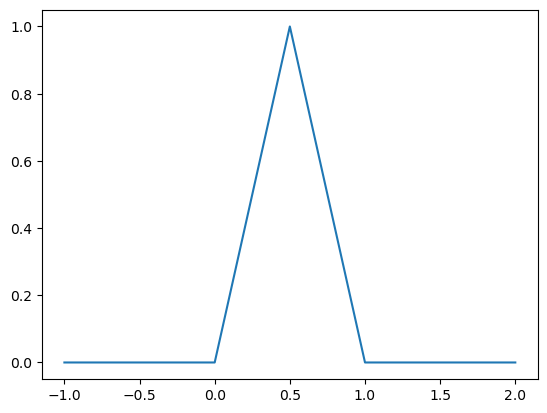

In [ ]:
# 3(a)

def my_fun(x):
    return torch.relu(torch.relu(x*torch.tensor(2)) - torch.relu(x*torch.tensor(4) - torch.tensor(2)))

x=torch.range(-1,2,0.1)

plt.plot(x, my_fun(x))

# For the following functions find by hand the parameters of a neural network that can
# fit these functions. You should use either a 1 or 2 hidden layer network and may use
# either sigmoid or ReLU non-linearities. In each case justify your answer and how you
# arrived at it (without using numerical/software packages).


tensor([1.6800])


/tmp/ipykernel_7772/2001599451.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-5,5,0.1)


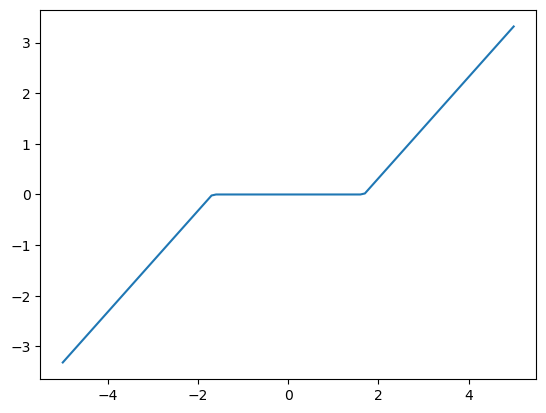

In [ ]:
x = torch.range(-5,5,0.1)
s = torch.randn(1)
def my_fun(x, s):
    return torch.max(torch.abs(x) - s, torch.tensor([0.])) * torch.sign(x)
print(s)
plt.plot(x,my_fun(x, s))

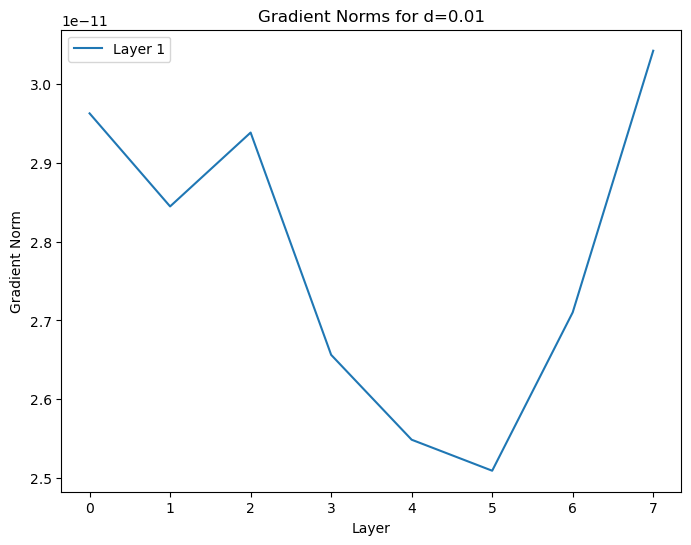

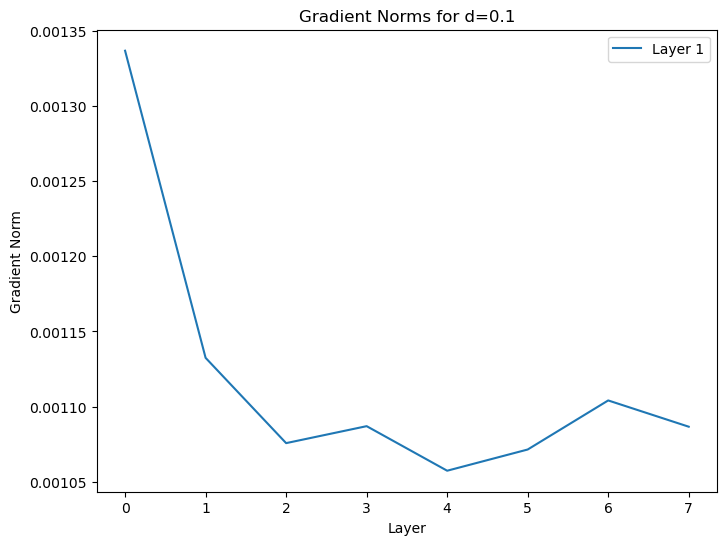

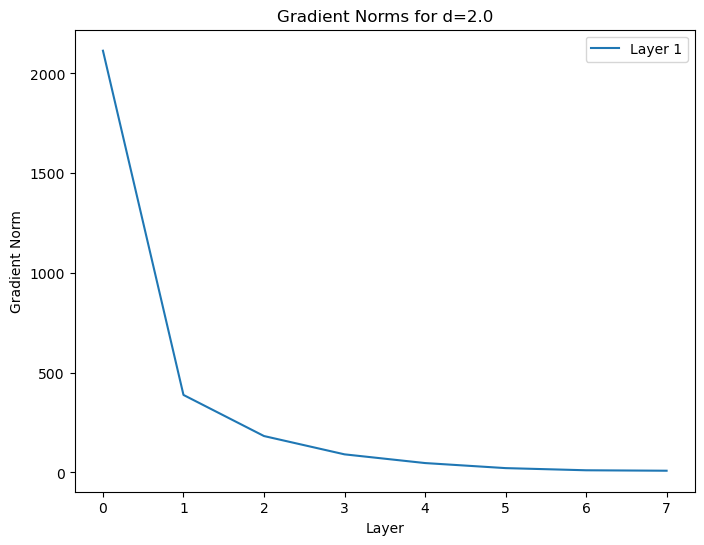

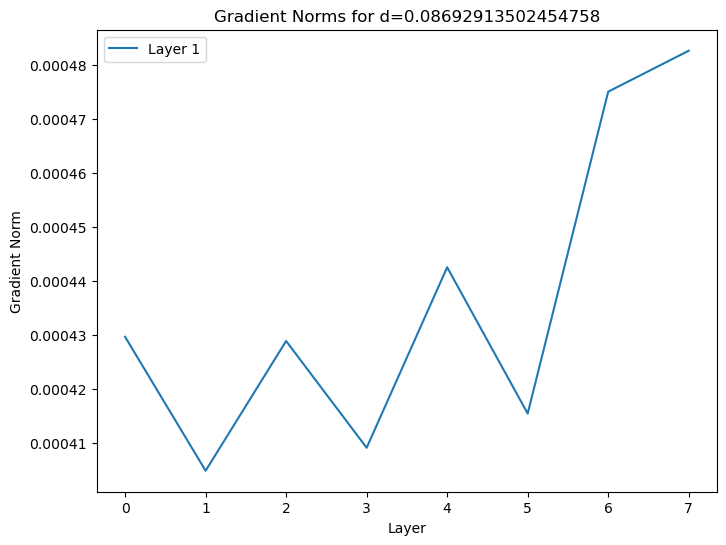

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.Floa

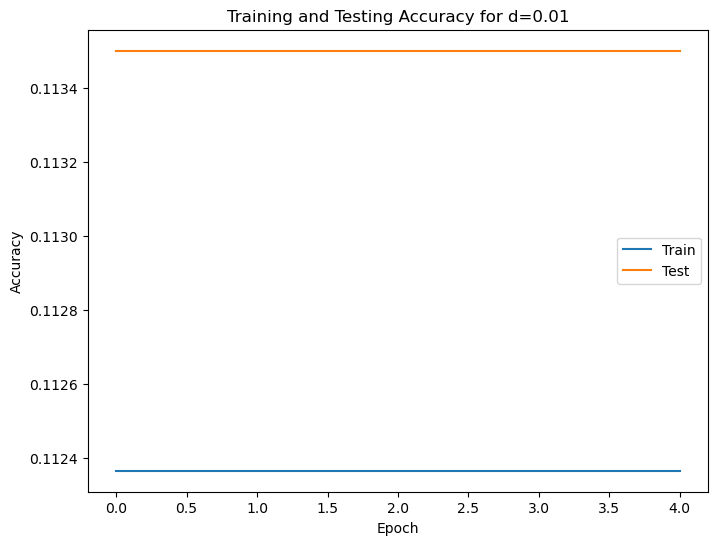

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.Floa

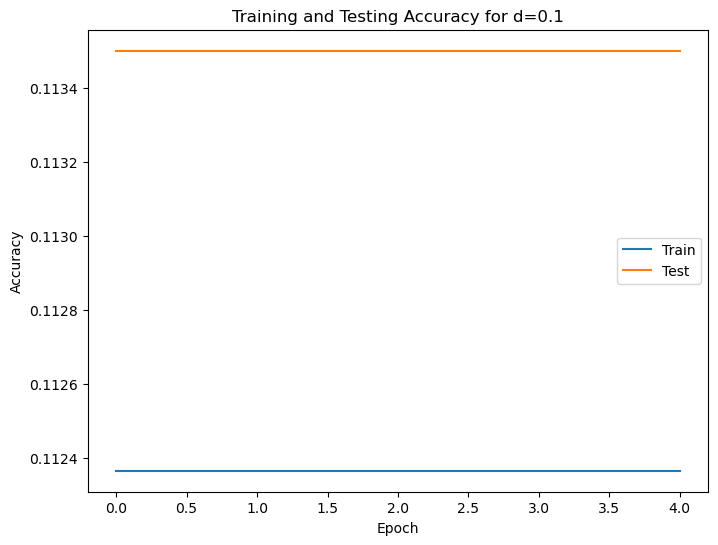

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.Floa

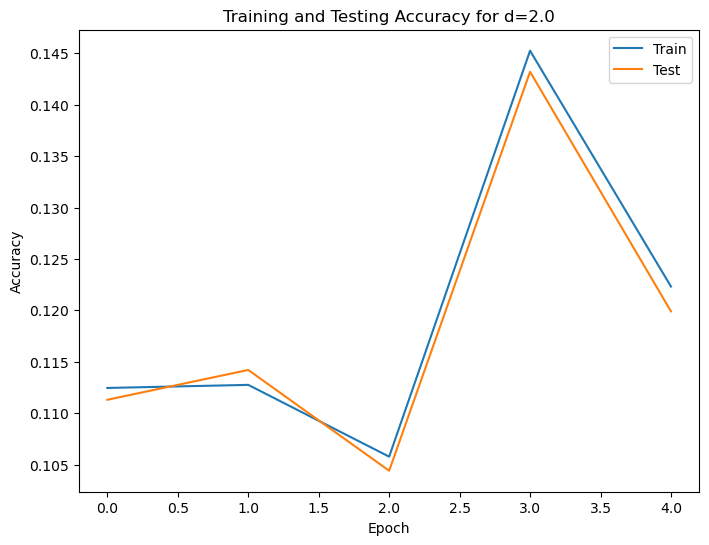

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.Floa

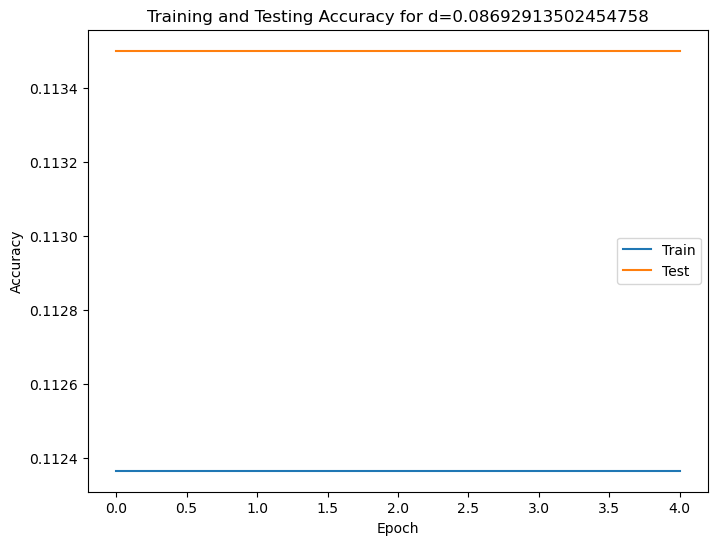

In [103]:
# question 4
device = 'cpu'
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
class MyModel(nn.Module):
    def __init__(self, depth):
        super(MyModel, self).__init__()
        self.depth = depth
        self.linear_list = nn.ModuleList([nn.Linear(784, 50)])
        for i in range(depth - 1):
            self.linear_list.append(nn.Linear(50, 50))
        self.output_layer = nn.Linear(50, 10)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = x.view(-1, 784)
        a_list = [x]
        for i in range(self.depth):
            x = self.linear_list[i](x)
            if i < self.depth - 1:
                x = self.activation(x)
            # Keep the gradient buffer from clearing at each layer
            x.retain_grad()
            a_list.append(x)
        output = self.output_layer(x)
        return output, a_list

    def init_weights(self, d):
        for i in range(self.depth):
            nn.init.uniform_(self.linear_list[i].weight, -d, d)
            nn.init.zeros_(self.linear_list[i].bias)
        nn.init.uniform_(self.output_layer.weight, -d, d)
        nn.init.zeros_(self.output_layer.bias)

    def loss(self, x, y):
        output, a_list = self.forward(x)
        loss_val = nn.CrossEntropyLoss()(output, y)
        return loss_val, a_list

# forward and backward a minibatch of 256 MNIST digits through the network with depth 8.
# Compute and visualize the gradient norm at each layer. Specifically this refers to
# the magnitude of (∂L/∂a), where a are the post-activation outputs. Your plots should have layer on
# the x-axis and gradient norm on the y-axis. Note that to get the gradient norms
# at each layer you can use retain grad on the layer outputs in the forward pass to
# keep the gradient buffer from clearing at each layer on the backward. Perform this
# for each of the 4 initializations to obtain 4 curves. Note: in this question you do
# not need to train or update the models.
def compute_grad_norms(model, d):
    # Initialize the model
    model.init_weights(d)

    # Load MNIST dataset
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,))
                                   ])), batch_size=256, shuffle=True)

    # Compute gradient norms at each layer for one minibatch
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        loss, a_list = model.loss(x, y)
        loss.backward()
        grad_norms = torch.zeros(model.depth, 1)
        for i in range(model.depth):
            grad_norms[i] = torch.norm(model.linear_list[i].weight.grad)
        grad_norms = grad_norms.cpu().detach().numpy()
        break

    # Plot the gradient norms for each layer
    plt.figure(figsize=(8,6))
    for i in range(grad_norms.shape[1]):
        plt.plot(grad_norms[:,i], label=f'Layer {i+1}')
    plt.title(f'Gradient Norms for d={d}')
    plt.xlabel('Layer')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.show()


# Test the function for all four initializations and depth 8
for d in [0.01, 0.1, 2.0, torch.sqrt(torch.tensor(6/(784+10)))]:
    model = MyModel(8)
    compute_grad_norms(model, d)

# For each of the initialization settings train the model for 5 epochs on
# MNIST, using the cross-entropy loss. You may use SGD with learning rate of 0.01
# and minibatch sizes of 128. Record the training accuracy and testing accuracy after
# each epoch and plot them versus epochs.
def train_model(model, d, epochs):
    # Initialize the model
    model.init_weights(d)

    # Load MNIST dataset
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,))
                                   ])), batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,))
                                   ])), batch_size=128, shuffle=True)

    # Train the model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_acc = []
    test_acc = []
    for epoch in range(epochs):
        # Train
        model.train()
        for x, y in train_loader:
            
            x = x.to(device)
            y = y.to(device)
            x.requires_grad_(True)
            optimizer.zero_grad()
            loss, _ = model.loss(x, y)
            loss.backward()
            optimizer.step()
        # Test
        model.eval()
        correct = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            x.requires_grad_(True)
            output, _ = model.forward(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
        train_acc.append(correct / len(train_loader.dataset))
        correct = 0
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            x.requires_grad_(True)
            output, _ = model.forward(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
        test_acc.append(correct / len(test_loader.dataset))
        print(f'Epoch {epoch+1}: Train Accuracy: {train_acc[-1]:.4f}, Test Accuracy: {test_acc[-1]:.4f}')

    # Plot the training and testing accuracy
    plt.figure(figsize=(8,6))
    plt.plot(train_acc, label='Train')
    plt.plot(test_acc, label='Test')
    plt.title(f'Training and Testing Accuracy for d={d}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Train the model for all four initializations and depth 8
for d in [0.01, 0.1, 2.0, torch.sqrt(torch.tensor(6/(784+10)))]:
    model = MyModel(8)
    train_model(model, d, 5)
